<a href="https://colab.research.google.com/github/codecx07/ZS-Data-Science-Challenge-2019/blob/master/ZS_Data_Science_Challenge_2019.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import xgboost
import matplotlib.pyplot as plt
import seaborn as sns
import logging

from sklearn import preprocessing
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import mean_absolute_error, explained_variance_score
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

logging.getLogger('googleapicliet.discovery_cache').setLevel(logging.ERROR)

Using TensorFlow backend.


In [2]:
# Link Google drive with Colab Notebook
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# Download files from Google Drive to Colab Notebook  
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/ZS Data Science Challenge 2019/data.csv')
train = df.copy()

In [4]:
print(train.shape)
train.head()

(30697, 27)


,match_event_id,location_x,location_y,remaining_min,power_of_shot,knockout_match,game_season,remaining_sec,distance_of_shot,is_goal,area_of_shot,shot_basics,range_of_shot,team_name,date_of_game,home/away,shot_id_number,lat/lng,type_of_shot,type_of_combined_shot,match_id,team_id,remaining_min.1,power_of_shot.1,knockout_match.1,remaining_sec.1,distance_of_shot.1
0,10.0,167.0,72.0,10.0,1.0,0.0,2000-01,27.0,38.0,NaN,Right Side(R),Mid Range,16-24 ft.,Manchester United,2000-10-31,MANU @ POR,1,"45.539131, -122.651648",shot - 30,NaN,20000012,1610612747,10.00,1.0,50.608,54.2000,38.0
1,12.0,-157.0,0.0,10.0,1.0,0.0,2000-01,22.0,35.0,0.0,Left Side(L),Mid Range,8-16 ft.,Manchester United,2000-10-31,MANU @ POR,2,"45.539131, -122.651648",shot - 45,NaN,20000012,1610612747,10.00,1.0,28.800,22.0000,35.0
2,35.0,-101.0,135.0,7.0,1.0,0.0,2000-01,45.0,36.0,1.0,Left Side Center(LC),Mid Range,16-24 ft.,Manchester United,2000-10-31,NaN,3,"45.539131, -122.651648",shot - 25,NaN,20000012,1610612747,92.64,1.0,0.000,63.7216,54.4
3,43.0,138.0,175.0,6.0,1.0,0.0,2000-01,52.0,42.0,0.0,Right Side Center(RC),Mid Range,16-24 ft.,Manchester United,2000-10-31,MANU @ POR,4,"45.539131, -122.651648",NaN,shot - 3,20000012,1610612747,NaN,1.0,122.608,52.0000,42.0
4,155.0,0.0,0.0,NaN,2.0,0.0,2000-01,19.0,20.0,1.0,Center(C),Goal Area,Less Than 8 ft.,NaN,2000-10-31,MANU @ POR,5,"45.539131, -122.651648",NaN,shot - 1,20000012,1610612747,42.64,2.0,0.000,19.0000,20.0


In [0]:
train['remaining_min'].fillna(0, inplace = True)
train['remaining_sec'].fillna(0, inplace = True)

In [6]:
train.columns

Index(['match_event_id', 'location_x', 'location_y', 'remaining_min',
       'power_of_shot', 'knockout_match', 'game_season', 'remaining_sec',
       'distance_of_shot', 'is_goal', 'area_of_shot', 'shot_basics',
       'range_of_shot', 'team_name', 'date_of_game', 'home/away',
       'shot_id_number', 'lat/lng', 'type_of_shot', 'type_of_combined_shot',
       'match_id', 'team_id', 'remaining_min.1', 'power_of_shot.1',
       'knockout_match.1', 'remaining_sec.1', 'distance_of_shot.1'],
      dtype='object')

In [0]:
del(train['team_name'])
del(train['team_id'])
del(train['match_event_id'])
del(train['date_of_game'])
del(train['remaining_min.1'])
del(train['power_of_shot.1'])
del(train['knockout_match.1'])
del(train['remaining_sec.1'])
del(train['distance_of_shot.1'])

In [8]:
train['lat/lng'].fillna(method = 'bfill', inplace = True)
train['lat/lng'].value_counts()

42.982923, -71.446094     14952
29.444994, -98.524120      1022
38.567296, -121.456638      887
39.739968, -104.954013      872
33.552026, -112.071667      861
29.740325, -95.365762       790
45.539131, -122.651648      786
46.667324, -94.419250       749
40.774891, -111.930790      740
37.754130, -122.437947      685
34.189593, -118.471724      625
32.757824, -96.786653       615
42.330507, -71.074655       526
35.103812, -89.964007       514
47.633181, -122.308343      427
28.549237, -81.372780       412
39.993941, -75.143458       393
42.379455, -83.115635       373
40.361408, -86.186052       351
43.717098, -79.395917       338
40.708999, -73.872430       329
38.919619, -77.015211       326
41.484971, -81.671552       322
35.492151, -97.519011       318
41.845137, -87.660450       311
33.768092, -84.393817       301
25.790710, -80.207819       296
30.018061, -90.022651       284
43.062206, -87.944754       284
40.643505, -73.939507       279
35.262047, -80.865746       224
49.25006

In [0]:
train['is_home'] = (train['lat/lng'] == '42.982923, -71.446094')

In [0]:
del(train['lat/lng'])

In [0]:
train['remaining_time'] = train['remaining_min'] * 60 + train['remaining_sec']

In [0]:
del(train['remaining_min'])
del(train['remaining_sec'])

In [13]:
len(train['match_id'].unique().tolist())

1559

In [14]:
len(train['home/away'].unique().tolist())

75

In [0]:
def change_value(from_col, to_col):
    sep = train.copy()
    sep = sep.dropna(axis=0, subset=[to_col])
    dic = {}
    for val in sep[from_col].unique():
        dic[val] = sep[to_col][sep[from_col] == val].unique()[0]
    for i, row in df.iterrows():
        if row[to_col] is np.nan:
            train.at[i,to_col] = dic[df.iloc[i][from_col]]

In [0]:
change_value('match_id', 'home/away')
train['knockout_match'].fillna(method = 'bfill', inplace = True)
train['game_season'].fillna(method = 'bfill', inplace = True)
train['power_of_shot'].fillna(method = 'bfill', inplace = True)

In [0]:
del(train['match_id'])

In [18]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30697 entries, 0 to 30696
Data columns (total 16 columns):
location_x               29236 non-null float64
location_y               29157 non-null float64
power_of_shot            30697 non-null float64
knockout_match           30697 non-null float64
game_season              30697 non-null object
distance_of_shot         29130 non-null float64
is_goal                  24429 non-null float64
area_of_shot             29195 non-null object
shot_basics              29122 non-null object
range_of_shot            29133 non-null object
home/away                30697 non-null object
shot_id_number           30697 non-null int64
type_of_shot             15417 non-null object
type_of_combined_shot    15280 non-null object
is_home                  30697 non-null bool
remaining_time           30697 non-null float64
dtypes: bool(1), float64(7), int64(1), object(7)
memory usage: 3.5+ MB


In [0]:
train.loc[train['type_of_combined_shot'].notnull(), 'type_of_combined_shot'] = 'str' + train['type_of_combined_shot'].astype(str)

In [0]:
train['type_of_shot'] = train.apply(
    lambda row: row['type_of_combined_shot'] if pd.isnull(row['type_of_shot']) else row['type_of_shot'],
    axis=1
)

In [0]:
del(train['type_of_combined_shot'])

In [22]:
train.isnull().sum()

location_x          1461
location_y          1540
power_of_shot          0
knockout_match         0
game_season            0
distance_of_shot    1567
is_goal             6268
area_of_shot        1502
shot_basics         1575
range_of_shot       1564
home/away              0
shot_id_number         0
type_of_shot           0
is_home                0
remaining_time         0
dtype: int64

In [23]:
train['power_of_shot'].value_counts()

3.0    8308
1.0    8032
4.0    7259
2.0    6721
5.0     330
6.0      40
7.0       7
Name: power_of_shot, dtype: int64

In [24]:
train['area_of_shot'].value_counts()

Center(C)                12761
Right Side Center(RC)     4562
Right Side(R)             4370
Left Side Center(LC)      3848
Left Side(L)              3573
Mid Ground(MG)              81
Name: area_of_shot, dtype: int64

In [25]:
train['shot_basics'].value_counts()

Mid Range          11955
Goal Area           6787
Penalty Spot        5321
Goal Line           4357
Right Corner         367
Left Corner          268
Mid Ground Line       67
Name: shot_basics, dtype: int64

In [26]:
train['range_of_shot'].value_counts()

Less Than 8 ft.    8933
16-24 ft.          7892
8-16 ft.           6290
24+ ft.            5937
Back Court Shot      81
Name: range_of_shot, dtype: int64

In [0]:
train['location_x'].fillna(train['location_x'].mean(), inplace = True)
train['location_y'].fillna(train['location_y'].mean(), inplace = True)
train['distance_of_shot'].fillna(train['distance_of_shot'].mean(), inplace = True)

In [0]:
def modify(df = train):
    train['range_of_shot'].loc[(train['shot_basics'] == 'Goal Area')] = 'Less Than 8 ft.'
    train['area_of_shot'].loc[(train['shot_basics'] == 'Goal Area')] = 'Center(C)'
    train['range_of_shot'].loc[(train['shot_basics'] == 'Left Corner')] = '24+ ft.'
    train['area_of_shot'].loc[(train['shot_basics'] == 'Left Corner')] = 'Left Side(L)'
    train['range_of_shot'].loc[(train['shot_basics'] == 'Mid Ground Line')] = 'Back Court Shot'
    train['area_of_shot'].loc[(train['shot_basics'] == 'Mid Ground Line')] = 'Mid Ground(MG)'
    train['range_of_shot'].loc[(train['shot_basics'] == 'Right Corner')] = '24+ ft.'
    train['area_of_shot'].loc[(train['shot_basics'] == 'Right Corner')] = 'Right Side(R)'
    train['shot_basics'].loc[(train['range_of_shot'] == '16-24 ft.')] = 'Mid Range'

    train['range_of_shot'].loc[(train['shot_basics'] == 'Goal Line') & (train['area_of_shot'] == 'Left Side(L)')] = '8-16 ft.'
    train['range_of_shot'].loc[(train['shot_basics'] == 'Goal Line') & (train['area_of_shot'] == 'Right Side(R)')] = '8-16 ft.'
    train['area_of_shot'].loc[(train['shot_basics'] == 'Goal Line') & (train['range_of_shot'] == 'Less Than 8 ft.')] = 'Center(C)'
    train['range_of_shot'].loc[(train['shot_basics'] == 'Mid Range') & (train['area_of_shot'] == 'Left Side Center(LC)')] = '16-24 ft.'
    train['range_of_shot'].loc[(train['shot_basics'] == 'Mid Range') & (train['area_of_shot'] == 'Right Side Center(RC)')] = '16-24 ft.'
    train['range_of_shot'].loc[(train['shot_basics'] == 'Penalty Spot') & (train['area_of_shot'] == 'Center(C)')] = '24+ ft.'
    train['range_of_shot'].loc[(train['shot_basics'] == 'Penalty Spot') & (train['area_of_shot'] == 'Left Side Center(LC)')] = '24+ ft.'
    train['range_of_shot'].loc[(train['shot_basics'] == 'Penalty Spot') & (train['area_of_shot'] == 'Right Side Center(RC)')] = '24+ ft.'
    train['shot_basics'].loc[(train['area_of_shot'] == 'Center(C)') & (train['range_of_shot'] == '24+ ft.')] = 'Penalty Spot'
    train['shot_basics'].loc[(train['area_of_shot'] == 'Left Side Center(LC)') & (train['range_of_shot'] == '24+ ft.')] = 'Penalty Spot'
    train['shot_basics'].loc[(train['area_of_shot'] == 'Right Side Center(RC)') & (train['range_of_shot'] == '24+ ft.')] = 'Penalty Spot'

In [29]:
modify(train)
train['area_of_shot'].fillna(train['area_of_shot'].mode()[0], inplace = True)

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [30]:
modify(train)
train['shot_basics'].fillna(train['shot_basics'].mode()[0], inplace = True)

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [31]:
modify(train)
train['range_of_shot'].fillna(method = 'bfill', inplace = True)

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [32]:
train.isnull().sum()

location_x             0
location_y             0
power_of_shot          0
knockout_match         0
game_season            0
distance_of_shot       0
is_goal             6268
area_of_shot           0
shot_basics            0
range_of_shot          0
home/away              0
shot_id_number         0
type_of_shot           0
is_home                0
remaining_time         0
dtype: int64

In [0]:
le = preprocessing.LabelEncoder()
train['game_season'] = le.fit_transform(train['game_season'])
train['area_of_shot'] = le.fit_transform(train['area_of_shot'])
train['shot_basics'] = le.fit_transform(train['shot_basics'])
train['range_of_shot'] = le.fit_transform(train['range_of_shot'])
train['home/away'] = le.fit_transform(train['home/away'])
train['type_of_shot'] = le.fit_transform(train['type_of_shot'])

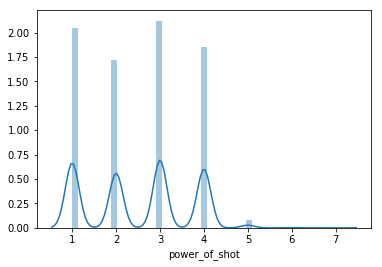

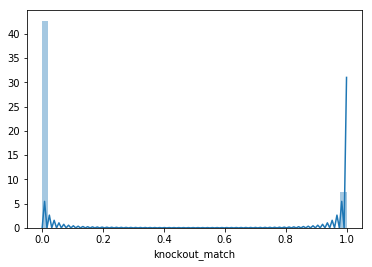

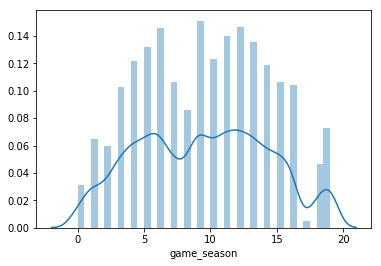

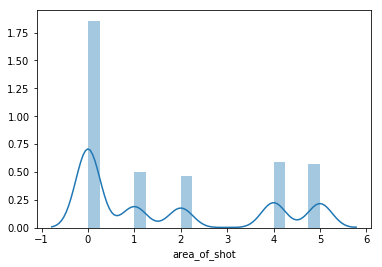

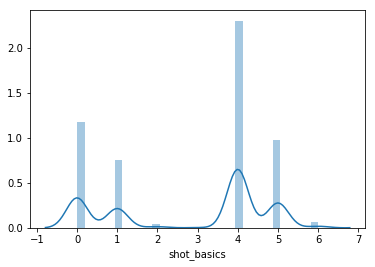

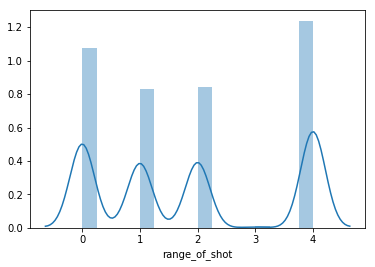

In [34]:
plt.figure()
sns.distplot(train['power_of_shot'])
plt.figure()
sns.distplot(train['knockout_match'])
plt.figure()
sns.distplot(train['game_season'])
plt.figure()
sns.distplot(train['area_of_shot'])
plt.figure()
sns.distplot(train['shot_basics'])
plt.figure()
sns.distplot(train['range_of_shot'])

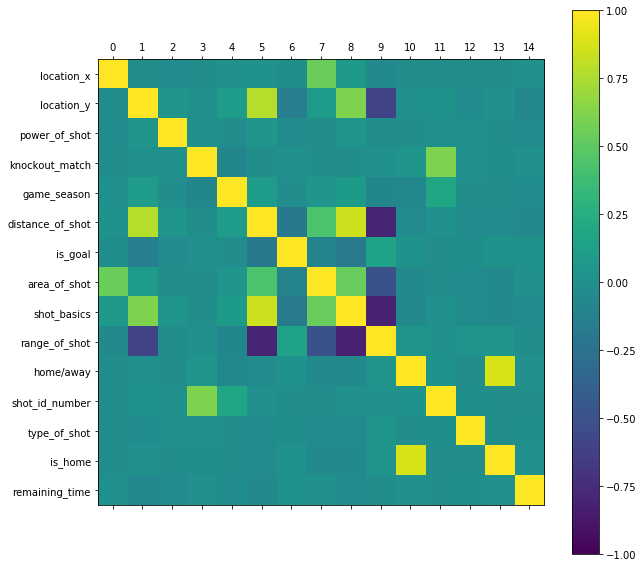

In [35]:
# Plotting a correlation matrix to check if any features can be removed to improve accuracy
correlations = train.corr()
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,15,1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_yticklabels(train.columns)
plt.show()

In [36]:
labels = ['game_season', 'area_of_shot', 'shot_basics', 'range_of_shot', 'home/away', 'type_of_shot']
for label in labels:
    dummies = pd.get_dummies(train[label]).rename(columns=lambda x: label + '_' + str(x))
    train = pd.concat([train, dummies], axis=1)
    train = train.drop([label], axis=1)
train.shape

(30697, 184)

In [0]:
sc = preprocessing.StandardScaler()
train[['location_x', 'location_y', 'power_of_shot', 'distance_of_shot', 'remaining_time']] = sc.fit_transform(train[['location_x', 'location_y', 'power_of_shot', 'distance_of_shot', 'remaining_time']])

In [0]:
train = train.drop(columns = ['shot_id_number'])

In [39]:
train_final = train.dropna(axis=0, subset=['is_goal'])
train_final.index = range(len(train_final))
print(len(train_final))
train_final.to_csv('train.csv', index = False)

test_final = train[train['is_goal'].isnull()]
test_final.index =  range(len(test_final))
print(len(test_final))
test_final.to_csv('test.csv', index = False)

24429
6268


In [0]:
def algo(clf):
    clf.fit(X_train_final,y_train_final)
    pred = clf.predict(X_train_final)
    pred_test = clf.predict(X_val_final)
    print (accuracy_score(y_train_final, pred))
    print (accuracy_score(y_val_final, pred_test))
    pred = clf.predict_proba(X_train_final)
    pred_test = clf.predict_proba(X_val_final)
    score = 1 / (1 + mean_absolute_error(y_train_final, pred[:, 1]))
    score_val = 1 / (1 + mean_absolute_error(y_val_final, pred_test[:, 1]))
    print(score, score_val)

In [0]:
def algo_final(clf):
    i=1
    kf = StratifiedKFold(n_splits=5,random_state=7,shuffle=True) 

    for train_index,test_index in kf.split(X_train,y_train):    
        print('\n{} of kfold {}'.format(i,kf.n_splits))   
        xtr,xvl = np.array(X_train.loc[train_index]),np.array(X_train.loc[test_index])     
        ytr,yvl = np.array(y_train[train_index]),np.array(y_train[test_index])    
        clf.fit(xtr, ytr)
        pred = clf.predict(xtr)
        pred_test = clf.predict(xvl)   
        print (accuracy_score(ytr, pred))
        print (accuracy_score(yvl, pred_test))   
        i+=1 

In [0]:
X_train = train_final.drop(columns = ['is_goal'])
y_train = train_final['is_goal']
# X_train_final, X_val_final, y_train_final, y_val_final = train_test_split(X_train, y_train, test_size=0.3, random_state=42)
# skf = StratifiedKFold(n_splits=2, random_state = 7, shuffle = True)
# skf.get_n_splits(X, y)
X_test_final = np.array(test_final.drop(columns = ['is_goal']))

In [43]:
# clf1 = LogisticRegression(C = 0.3, penalty = 'l1', solver = 'liblinear', random_state = 7, max_iter = 1000)
# algo_final(clf1)
parameters = {
    'penalty' : ('l1', 'l2'),
    'C' : [0.03, 0.1, 0.3, 1, 3],
    'solver' : ('liblinear', 'saga')
}
gs = GridSearchCV(estimator = LogisticRegression(random_state = 7, max_iter = 1000), param_grid = parameters, n_jobs = 4, scoring = 'accuracy', iid =  False, cv = 3)
gs.fit(X_train,y_train)
gs.best_params_, gs.best_score_

({'C': 0.3, 'penalty': 'l1', 'solver': 'liblinear'}, 0.6155798198126754)

In [44]:
clf = GaussianNB()
algo_final(clf)


1 of kfold 5
0.5105152740111549
0.49979533360622186

2 of kfold 5
0.5308806222176738
0.5186246418338109

3 of kfold 5
0.5379931433249757
0.5249693000409332

4 of kfold 5
0.5252520083917516
0.5169873106835857

5 of kfold 5
0.5298812934916087
0.5230296827021494


In [45]:
clf2 = SGDClassifier(max_iter=1000, tol=1e-3)
algo_final(clf)


1 of kfold 5
0.5105152740111549
0.49979533360622186

2 of kfold 5
0.5308806222176738
0.5186246418338109

3 of kfold 5
0.5379931433249757
0.5249693000409332

4 of kfold 5
0.5252520083917516
0.5169873106835857

5 of kfold 5
0.5298812934916087
0.5230296827021494


In [46]:
# clf = KNeighborsClassifier(n_neighbors=3)
# algo_final(clf)
parameters = {
    'n_neighbors' : [1, 3, 10],
    'weights' : ('uniform', 'distance')
}
gs = GridSearchCV(estimator = KNeighborsClassifier(algorithm = 'auto'), param_grid = parameters, n_jobs = 4, scoring = 'accuracy', iid =  False, cv = 3)
gs.fit(X_train,y_train)
gs.best_params_, gs.best_score_

({'n_neighbors': 10, 'weights': 'uniform'}, 0.588275978669664)

In [47]:
# clf2 = DecisionTreeClassifier(max_depth=10, random_state = 7)
# algo_final(clf2)
parameters = {
    'max_depth' : [1, 3, 10, 30]
}
gs = GridSearchCV(estimator = DecisionTreeClassifier(random_state = 7), param_grid = parameters, n_jobs = 4, scoring = 'accuracy', iid =  False, cv = 3)
gs.fit(X_train,y_train)
gs.best_params_, gs.best_score_

({'max_depth': 10}, 0.612878359088762)

In [48]:
# clf2 = RandomForestClassifier(n_estimators=100, max_depth=30, random_state = 7)
# algo_final(clf2)
parameters = {
    'max_depth' : [1, 3, 10, 30]
}
gs = GridSearchCV(estimator = RandomForestClassifier(n_estimators=100, random_state = 7), param_grid = parameters, n_jobs = 4, scoring = 'accuracy', iid =  False, cv = 3)
gs.fit(X_train,y_train)
gs.best_params_, gs.best_score_

({'max_depth': 30}, 0.6203690536407042)

In [0]:
# clf = SVC(gamma='auto')
# algo_final(clf)
# parameters = {
#     'C' : [0.03, 0.1, 0.3, 1, 3],
#     'kernel' : ('linear', 'poly', 'rbf', 'sigmoid'),
#     'degree' : [1, 3, 10],
#     'coef0' : [0.03, 0.1, 0.3, 1, 3]
# }
# gs = GridSearchCV(estimator = SVC(gamma='auto', random_state = 7), param_grid = parameters, n_jobs = 4, scoring = 'accuracy', iid =  False, cv = 3)
# gs.fit(X_train,y_train)
# gs.best_params_, gs.best_score_

In [0]:
# clf3 = xgboost.XGBClassifier(n_estimators = 100, max_depth = 3, learning_rate = 0.1, random_state = 7)
# algo_final(clf3)
# parameters = {
#     'max_depth' : [1, 3, 10, 30],
#     'learning_rate' : [0.003, 0.01, 0.03, 0.1, 0.3, 1, 3]
# }
# gs = GridSearchCV(estimator = xgboost.XGBClassifier(n_estimators = 100, random_state = 7), param_grid = parameters, n_jobs = 4, scoring = 'accuracy', iid =  False, cv = 3)
# gs.fit(X_train,y_train)
# gs.best_params_, gs.best_score_

In [0]:
# baseline model
def create_baseline():
    # create model
    model = Sequential()
    model.add(Dense(182, input_dim=182, kernel_initializer='normal', activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(91, kernel_initializer='normal', activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [52]:
X_train = train_final.drop(columns = ['is_goal'])
y_train = train_final['is_goal']
X_train.shape

(24429, 182)

In [53]:
X_train = train_final.drop(columns = ['is_goal'])
y_train = train_final['is_goal']
# evaluate model with standardized dataset
estimator = KerasClassifier(build_fn=create_baseline, epochs=15, batch_size=5, verbose=2)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)
results = cross_val_score(estimator, X_train, y_train, cv=kfold)
print("Results: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

W0726 21:20:52.934831 140526618965888 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0726 21:20:52.984432 140526618965888 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0726 21:20:52.995251 140526618965888 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4115: The name tf.random_normal is deprecated. Please use tf.random.normal instead.

W0726 21:20:53.022727 140526618965888 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0726 21:20:53.036244 14

Epoch 1/15
 - 7s - loss: 0.6611 - acc: 0.6100
Epoch 2/15
 - 6s - loss: 0.6476 - acc: 0.6262
Epoch 3/15
 - 6s - loss: 0.6401 - acc: 0.6360
Epoch 4/15
 - 6s - loss: 0.6341 - acc: 0.6400
Epoch 5/15
 - 6s - loss: 0.6293 - acc: 0.6423
Epoch 6/15
 - 6s - loss: 0.6245 - acc: 0.6478
Epoch 7/15
 - 6s - loss: 0.6190 - acc: 0.6508
Epoch 8/15
 - 7s - loss: 0.6133 - acc: 0.6534
Epoch 9/15
 - 7s - loss: 0.6113 - acc: 0.6563
Epoch 10/15
 - 7s - loss: 0.6049 - acc: 0.6590
Epoch 11/15
 - 7s - loss: 0.5976 - acc: 0.6667
Epoch 12/15
 - 7s - loss: 0.5943 - acc: 0.6703
Epoch 13/15
 - 7s - loss: 0.5891 - acc: 0.6741
Epoch 14/15
 - 7s - loss: 0.5818 - acc: 0.6765
Epoch 15/15
 - 6s - loss: 0.5782 - acc: 0.6810
Epoch 1/15
 - 7s - loss: 0.6579 - acc: 0.6147
Epoch 2/15
 - 7s - loss: 0.6454 - acc: 0.6311
Epoch 3/15
 - 7s - loss: 0.6399 - acc: 0.6319
Epoch 4/15
 - 7s - loss: 0.6364 - acc: 0.6410
Epoch 5/15
 - 7s - loss: 0.6317 - acc: 0.6403
Epoch 6/15
 - 7s - loss: 0.6283 - acc: 0.6435
Epoch 7/15
 - 7s - loss: 0.6

In [54]:
estimator.fit(X_train, y_train)

Epoch 1/15
 - 10s - loss: 0.6582 - acc: 0.6143
Epoch 2/15
 - 8s - loss: 0.6461 - acc: 0.6296
Epoch 3/15
 - 9s - loss: 0.6389 - acc: 0.6344
Epoch 4/15
 - 9s - loss: 0.6364 - acc: 0.6369
Epoch 5/15
 - 9s - loss: 0.6339 - acc: 0.6409
Epoch 6/15
 - 9s - loss: 0.6292 - acc: 0.6443
Epoch 7/15
 - 9s - loss: 0.6253 - acc: 0.6451
Epoch 8/15
 - 9s - loss: 0.6208 - acc: 0.6491
Epoch 9/15
 - 9s - loss: 0.6157 - acc: 0.6506
Epoch 10/15
 - 9s - loss: 0.6129 - acc: 0.6536
Epoch 11/15
 - 9s - loss: 0.6088 - acc: 0.6561
Epoch 12/15
 - 9s - loss: 0.6058 - acc: 0.6573
Epoch 13/15
 - 9s - loss: 0.6012 - acc: 0.6613
Epoch 14/15
 - 9s - loss: 0.5955 - acc: 0.6654
Epoch 15/15
 - 9s - loss: 0.5909 - acc: 0.6706


In [0]:
# y_final = (clf1.predict_proba(X_test_final) + clf2.predict_proba(X_test_final) + clf3.predict_proba(X_test_final)) / 3
X_test_final = np.array(test_final.drop(columns = ['is_goal']))
y_final = estimator.predict_proba(X_test_final)

In [56]:
y_final = pd.DataFrame(y_final[:,1])
len(y_final)

6268

In [57]:
df = df[df['is_goal'].isnull()]
len(df)

6268

In [0]:
x = pd.DataFrame(df['shot_id_number'], columns=['shot_id_number'])#, index = y_final.index)
# x = x.dropna()
x.index = range(len(y_final))
x['is_goal'] = y_final

In [0]:
# x.to_csv('varun_bhargava_091698_prediction_6.csv', index = False)